# Milestone 2: baseline models
___

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import import_preprocess, baseline_models, evaluate
from importlib import reload
reload(import_preprocess)
reload(baseline_models)
reload(evaluate)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int
from baseline_models import XGBoostClassifier, MajorityClassClassifier, RuleBasedClassifier, NaiveBayesClassifier, LogisticRegression, LSTM_Model, get_all_predictions

2024-12-13 18:27:10.664115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 18:27:10.664147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 18:27:10.665204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 18:27:10.671479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 18:27:11.294074: W tensorflow/compiler/tf2

In [2]:
# !pip install tensorflow

In [3]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset()

X_train, y_train, S_train = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train
X_val, y_val, S_val = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val
X_test, y_test, S_test = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test
X_balanced, y_balanced = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 
print("Number of balanced samples:", len(X_balanced))

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 10000


In [4]:
# import_preprocess.convert_class_labels()
# y_train, y_dev, y_test = import_preprocess.y_train, import_preprocess.y_dev, import_preprocess.y_test

In [5]:
#X_train_dev, y_train_val = import_preprocess.concatenate_train_val()
#len(X_train_dev)
S_train[1]

'This is like the Metallica video where the poor mutilated bastard was saying "Please kill me" over and over again, only with emojis instead of Morse code.'

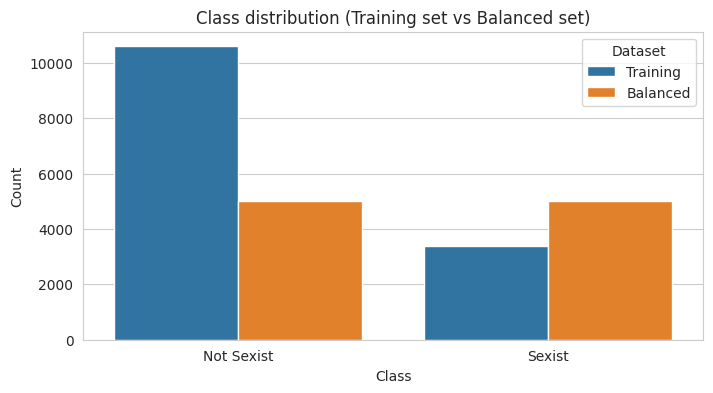

In [6]:
plot_data = pd.DataFrame({
    'Class': ['Not Sexist', 'Sexist'],
    'Training': [y_train.count('not sexist'), y_train.count('sexist')],
    'Balanced': [y_balanced.count('not sexist'), y_balanced.count('sexist')]
})
plot_data_melted = plot_data.melt(id_vars='Class', var_name='Dataset', value_name='Count')
plt.figure(figsize=(8, 4))
sns.barplot(x='Class', y='Count', hue='Dataset', data=plot_data_melted)
plt.title('Class distribution (Training set vs Balanced set)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [7]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])

#### a) Traditional (non-DL) baseline models

1. majority class classifier

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.7573
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



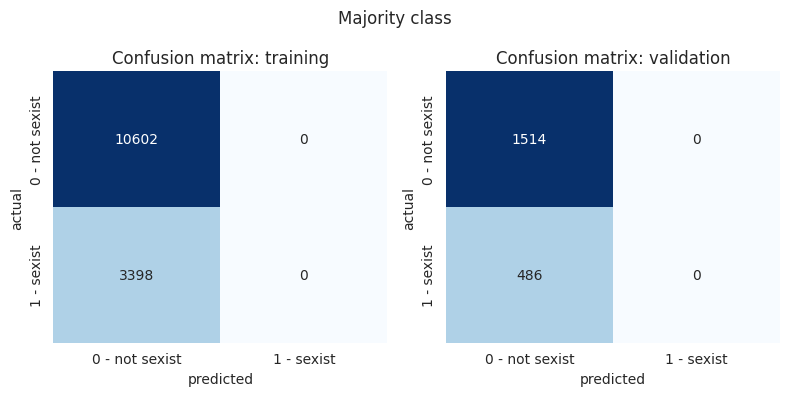

In [8]:
majority_class_classifier = MajorityClassClassifier()
majority_class_classifier.train(None, y_train, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

res = majority_class_classifier.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="Majority class")
for res_x in res:
    results.loc[len(results)] = res_x

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.5000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



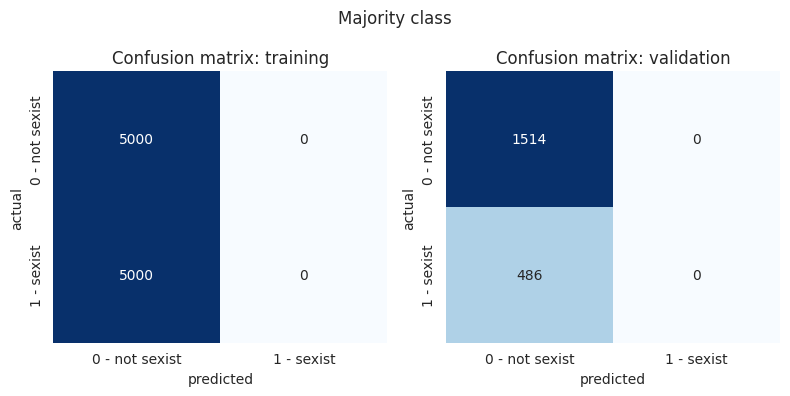

In [9]:
majority_class_classifier.train(None, y_balanced, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

res = majority_class_classifier.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="Majority class")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

2. regex classifier (rule-based)

########################################

Metrics for training
accuracy: 0.7164
balanced accuracy: 0.5732
precision: 0.3890
recall: 0.2949

########################################

Metrics for validation
accuracy: 0.7075
balanced accuracy: 0.5630
precision: 0.3673
recall: 0.2819

########################################



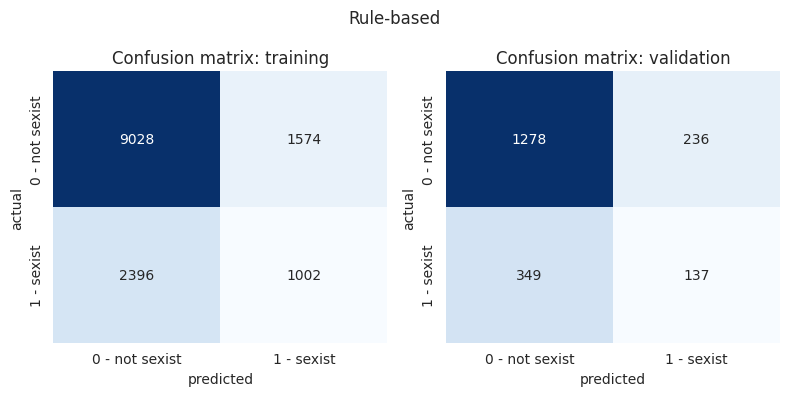

In [10]:
patterns = [
    r"\b(slut|bitch|fuck|fucking|sex)\b",
    r"\b(she has|she has to|she must|she shouldn't|women have to|women must|women shouldn't)\b",
    r"\b(hate|die)\b"
]

regex_classifier = RuleBasedClassifier(patterns)
res = regex_classifier.evaluate({"training": S_train, "validation": S_val}, [y_train, y_val], model_name="Rule-based")
for res_x in res:
    results.loc[len(results)] = res_x

3. Naive Bayes (NB)

########################################

Metrics for training
accuracy: 0.8650
balanced accuracy: 0.7943
precision: 0.7551
recall: 0.6569

########################################

Metrics for validation
accuracy: 0.8155
balanced accuracy: 0.7140
precision: 0.6519
recall: 0.5165

########################################



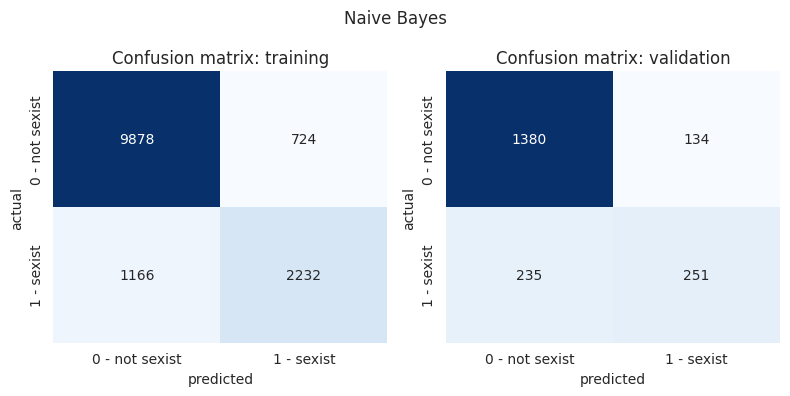

In [11]:
X_train_bow, X_val_bow, X_test_bow, X_train_val_bow, feature_names = import_preprocess.create_bow_representation()

naive_bayes_classifier = NaiveBayesClassifier()
naive_bayes_classifier.train(X_train_bow, y_train, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Naive Bayes")
for res_x in res:
    results.loc[len(results)] = res_x

########################################

Metrics for training
accuracy: 0.8378
balanced accuracy: 0.8378
precision: 0.8249
recall: 0.8576

########################################

Metrics for validation
accuracy: 0.6915
balanced accuracy: 0.6824
precision: 0.4157
recall: 0.6646

########################################



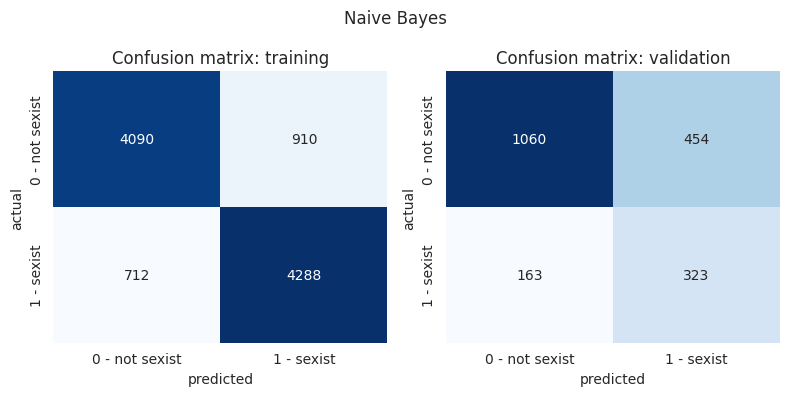

In [12]:
X_train_balanced_bow, X_val_balanced_bow, X_test_balanced_bow, X_train_val_balanced_bow, feature_names = import_preprocess.create_bow_representation(balanced=True)
naive_bayes_classifier.train(X_train_balanced_bow, y_balanced, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="Naive Bayes")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

4. Logisitic Regression

########################################

Metrics for training
accuracy: 0.8919
balanced accuracy: 0.8021
precision: 0.8955
recall: 0.6277

########################################

Metrics for validation
accuracy: 0.8310
balanced accuracy: 0.7081
precision: 0.7403
recall: 0.4691

########################################



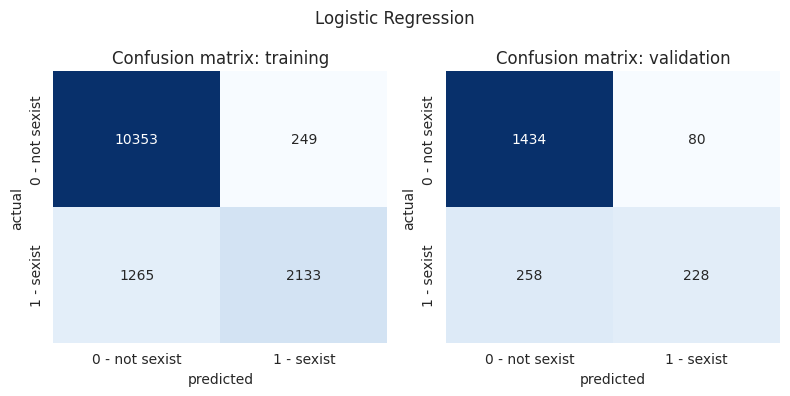

In [13]:
log_reg_classifier = LogisticRegression()
log_reg_classifier.train(X_train_bow, y_train, None, None)

res = log_reg_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Logistic Regression")
for res_x in res:
    results.loc[len(results)] = res_x

########################################

Metrics for training
accuracy: 0.9224
balanced accuracy: 0.9224
precision: 0.9353
recall: 0.9076

########################################

Metrics for validation
accuracy: 0.6495
balanced accuracy: 0.5757
precision: 0.3307
recall: 0.4321

########################################



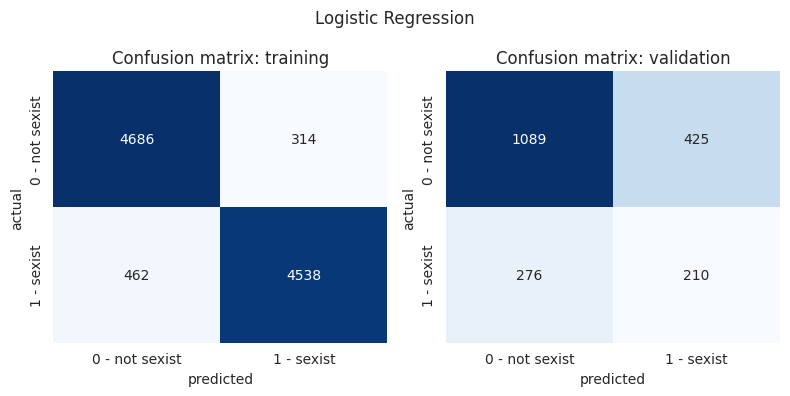

In [14]:
log_reg_classifier.train(X_train_balanced_bow, y_balanced, None, None)

res = log_reg_classifier.evaluate({"training": X_train_balanced_bow, "validation": X_val_bow}, [y_balanced, y_val], model_name="Logistic Regression")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (using BoW representation)

[0]	train-logloss:0.53009	eval-logloss:0.53454
[1]	train-logloss:0.51116	eval-logloss:0.51866
[2]	train-logloss:0.49586	eval-logloss:0.50590
[3]	train-logloss:0.48348	eval-logloss:0.49566
[4]	train-logloss:0.47308	eval-logloss:0.48727
[5]	train-logloss:0.46405	eval-logloss:0.48068
[6]	train-logloss:0.45658	eval-logloss:0.47452
[7]	train-logloss:0.44996	eval-logloss:0.47000
[8]	train-logloss:0.44414	eval-logloss:0.46612
[9]	train-logloss:0.43921	eval-logloss:0.46179
[10]	train-logloss:0.43483	eval-logloss:0.45844
[11]	train-logloss:0.43071	eval-logloss:0.45608
[12]	train-logloss:0.42720	eval-logloss:0.45407
[13]	train-logloss:0.42371	eval-logloss:0.45154
[14]	train-logloss:0.42068	eval-logloss:0.44925
[15]	train-logloss:0.41710	eval-logloss:0.44717
[16]	train-logloss:0.41453	eval-logloss:0.44600
[17]	train-logloss:0.41212	eval-logloss:0.44429
[18]	train-logloss:0.40972	eval-logloss:0.44285
[19]	train-logloss:0.40777	eval-logloss:0.44189
[20]	train-logloss:0.40607	eval-logloss:0.44081
[2

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:27:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	train-logloss:0.38090	eval-logloss:0.42528
[37]	train-logloss:0.37976	eval-logloss:0.42438
[38]	train-logloss:0.37863	eval-logloss:0.42375
[39]	train-logloss:0.37725	eval-logloss:0.42305
[40]	train-logloss:0.37627	eval-logloss:0.42224
[41]	train-logloss:0.37548	eval-logloss:0.42184
[42]	train-logloss:0.37438	eval-logloss:0.42115
[43]	train-logloss:0.37358	eval-logloss:0.42078
[44]	train-logloss:0.37271	eval-logloss:0.42026
[45]	train-logloss:0.37128	eval-logloss:0.41980
[46]	train-logloss:0.37034	eval-logloss:0.41918
[47]	train-logloss:0.36971	eval-logloss:0.41839
[48]	train-logloss:0.36880	eval-logloss:0.41758
[49]	train-logloss:0.36764	eval-logloss:0.41709
[50]	train-logloss:0.36652	eval-logloss:0.41662
[51]	train-logloss:0.36570	eval-logloss:0.41649
[52]	train-logloss:0.36503	eval-logloss:0.41626
[53]	train-logloss:0.36426	eval-logloss:0.41597
[54]	train-logloss:0.36359	eval-logloss:0.41557
[55]	train-logloss:0.36301	eval-logloss:0.41498
[56]	train-logloss:0.36216	eval-logloss:

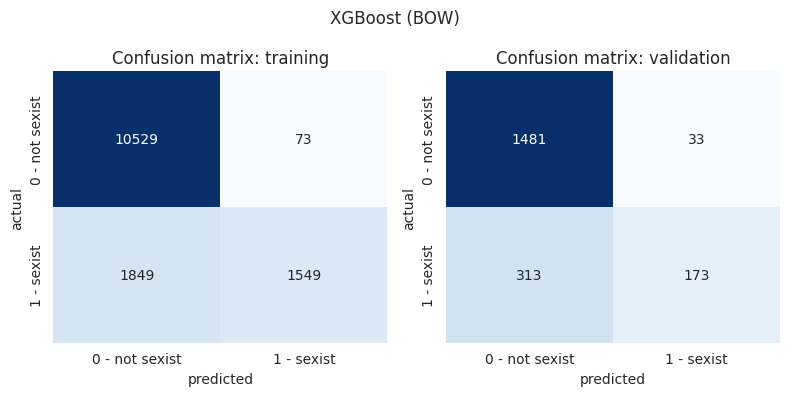

In [15]:
xg_boost_bow = XGBoostClassifier()
xg_boost_bow.train(X_train_bow, y_train, X_val_bow, y_val)

res = xg_boost_bow.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.66702	eval-logloss:0.66994
[1]	train-logloss:0.64562	eval-logloss:0.65090
[2]	train-logloss:0.62782	eval-logloss:0.63509
[3]	train-logloss:0.61265	eval-logloss:0.62151
[4]	train-logloss:0.59976	eval-logloss:0.61016
[5]	train-logloss:0.58872	eval-logloss:0.60026
[6]	train-logloss:0.57906	eval-logloss:0.59213
[7]	train-logloss:0.57089	eval-logloss:0.58451
[8]	train-logloss:0.56388	eval-logloss:0.57800
[9]	train-logloss:0.55691	eval-logloss:0.57262
[10]	train-logloss:0.55067	eval-logloss:0.56713
[11]	train-logloss:0.54453	eval-logloss:0.56290
[12]	train-logloss:0.53944	eval-logloss:0.55920
[13]	train-logloss:0.53503	eval-logloss:0.55565
[14]	train-logloss:0.53048	eval-logloss:0.55176
[15]	train-logloss:0.52546	eval-logloss:0.54964
[16]	train-logloss:0.52119	eval-logloss:0.54647
[17]	train-logloss:0.51772	eval-logloss:0.54374
[18]	train-logloss:0.51459	eval-logloss:0.54223
[19]	train-logloss:0.51163	eval-logloss:0.53939
[20]	train-logloss:0.50916	eval-logloss:0.53717
[2

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:27:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[57]	train-logloss:0.44153	eval-logloss:0.50251
[58]	train-logloss:0.44051	eval-logloss:0.50204
[59]	train-logloss:0.43951	eval-logloss:0.50170
[60]	train-logloss:0.43767	eval-logloss:0.50114
[61]	train-logloss:0.43639	eval-logloss:0.50043
[62]	train-logloss:0.43476	eval-logloss:0.50023
[63]	train-logloss:0.43389	eval-logloss:0.49944
[64]	train-logloss:0.43306	eval-logloss:0.49898
[65]	train-logloss:0.43217	eval-logloss:0.49890
[66]	train-logloss:0.43098	eval-logloss:0.49831
[67]	train-logloss:0.42971	eval-logloss:0.49830
[68]	train-logloss:0.42887	eval-logloss:0.49760
[69]	train-logloss:0.42790	eval-logloss:0.49740
[70]	train-logloss:0.42662	eval-logloss:0.49723
[71]	train-logloss:0.42531	eval-logloss:0.49701
[72]	train-logloss:0.42453	eval-logloss:0.49660
[73]	train-logloss:0.42244	eval-logloss:0.49604
[74]	train-logloss:0.42152	eval-logloss:0.49555
[75]	train-logloss:0.42041	eval-logloss:0.49557
[76]	train-logloss:0.41965	eval-logloss:0.49518
[77]	train-logloss:0.41868	eval-logloss:

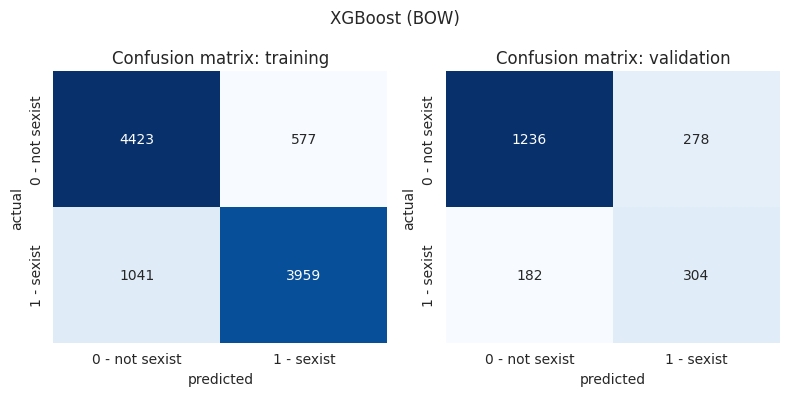

In [16]:
xg_boost_bow.train(X_train_balanced_bow, y_balanced, X_val_balanced_bow, y_val)

res = xg_boost_bow.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (TF-IDF representation)

[0]	train-logloss:0.52958	eval-logloss:0.53394


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:27:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	train-logloss:0.51006	eval-logloss:0.51771
[2]	train-logloss:0.49477	eval-logloss:0.50527
[3]	train-logloss:0.48208	eval-logloss:0.49567
[4]	train-logloss:0.47150	eval-logloss:0.48764
[5]	train-logloss:0.46256	eval-logloss:0.48115
[6]	train-logloss:0.45455	eval-logloss:0.47554
[7]	train-logloss:0.44794	eval-logloss:0.47048
[8]	train-logloss:0.44167	eval-logloss:0.46661
[9]	train-logloss:0.43624	eval-logloss:0.46296
[10]	train-logloss:0.43158	eval-logloss:0.45925
[11]	train-logloss:0.42734	eval-logloss:0.45712
[12]	train-logloss:0.42351	eval-logloss:0.45468
[13]	train-logloss:0.42008	eval-logloss:0.45318
[14]	train-logloss:0.41695	eval-logloss:0.45141
[15]	train-logloss:0.41380	eval-logloss:0.44947
[16]	train-logloss:0.41114	eval-logloss:0.44779
[17]	train-logloss:0.40869	eval-logloss:0.44596
[18]	train-logloss:0.40639	eval-logloss:0.44461
[19]	train-logloss:0.40376	eval-logloss:0.44379
[20]	train-logloss:0.40192	eval-logloss:0.44245
[21]	train-logloss:0.40015	eval-logloss:0.44112
[

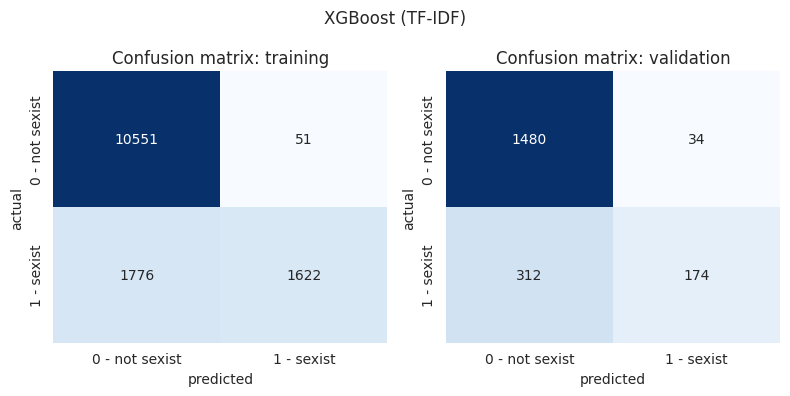

In [17]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, X_train_val_tfidf, feature_names = import_preprocess.create_tfidf_representation()

xg_boost_tfidf = XGBoostClassifier()
xg_boost_tfidf.train(X_train_tfidf, y_train, X_val_tfidf, y_val)

res = xg_boost_tfidf.evaluate({"training": X_train_tfidf, "validation": X_val_tfidf}, [y_train, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.66676	eval-logloss:0.66919
[1]	train-logloss:0.64497	eval-logloss:0.64957
[2]	train-logloss:0.62694	eval-logloss:0.63331
[3]	train-logloss:0.61055	eval-logloss:0.62006
[4]	train-logloss:0.59746	eval-logloss:0.60837
[5]	train-logloss:0.58573	eval-logloss:0.59832
[6]	train-logloss:0.57458	eval-logloss:0.58991
[7]	train-logloss:0.56573	eval-logloss:0.58225


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:27:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	train-logloss:0.55787	eval-logloss:0.57566
[9]	train-logloss:0.54979	eval-logloss:0.56961
[10]	train-logloss:0.54272	eval-logloss:0.56504
[11]	train-logloss:0.53665	eval-logloss:0.56082
[12]	train-logloss:0.53108	eval-logloss:0.55695
[13]	train-logloss:0.52579	eval-logloss:0.55319
[14]	train-logloss:0.52054	eval-logloss:0.54920
[15]	train-logloss:0.51638	eval-logloss:0.54601
[16]	train-logloss:0.51159	eval-logloss:0.54304
[17]	train-logloss:0.50838	eval-logloss:0.53978
[18]	train-logloss:0.50368	eval-logloss:0.53774
[19]	train-logloss:0.50065	eval-logloss:0.53537
[20]	train-logloss:0.49739	eval-logloss:0.53311
[21]	train-logloss:0.49376	eval-logloss:0.53141
[22]	train-logloss:0.49113	eval-logloss:0.52969
[23]	train-logloss:0.48880	eval-logloss:0.52825
[24]	train-logloss:0.48564	eval-logloss:0.52682
[25]	train-logloss:0.48293	eval-logloss:0.52548
[26]	train-logloss:0.48018	eval-logloss:0.52467
[27]	train-logloss:0.47814	eval-logloss:0.52333
[28]	train-logloss:0.47607	eval-logloss:0.

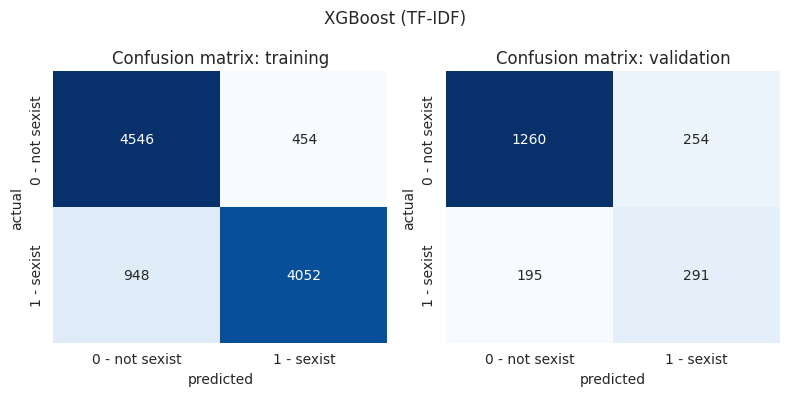

In [18]:
X_train_balanced_tfidf, X_val_balanced_tfidf, X_test_balanced_tfidf, X_train_val_balanced_tfidf, feature_names = import_preprocess.create_tfidf_representation(balanced=True)

xg_boost_tfidf.train(X_train_balanced_tfidf, y_balanced, X_val_balanced_tfidf, y_val)

res = xg_boost_tfidf.evaluate({"training": X_train_balanced_tfidf, "validation": X_val_balanced_tfidf}, [y_balanced, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

#### b) DL baseline models

1. LSTM

Epoch 1/10


2024-12-13 18:27:29.859825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-13 18:27:29.880710: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


438/438 [==============================] - 6s 12ms/step - loss: 0.5480 - accuracy: 0.7571 - val_loss: 0.4946 - val_accuracy: 0.7700
Epoch 2/10
438/438 [==============================] - 5s 12ms/step - loss: 0.4435 - accuracy: 0.8126 - val_loss: 0.4572 - val_accuracy: 0.8055
Epoch 3/10
438/438 [==============================] - 5s 12ms/step - loss: 0.3594 - accuracy: 0.8535 - val_loss: 0.4153 - val_accuracy: 0.8255
Epoch 4/10
438/438 [==============================] - 5s 12ms/step - loss: 0.3155 - accuracy: 0.8782 - val_loss: 0.4089 - val_accuracy: 0.8295
Epoch 5/10
438/438 [==============================] - 5s 12ms/step - loss: 0.2854 - accuracy: 0.8921 - val_loss: 0.4138 - val_accuracy: 0.8235
Epoch 6/10
438/438 [==============================] - 5s 11ms/step - loss: 0.2589 - accuracy: 0.9070 - val_loss: 0.4236 - val_accuracy: 0.8330
Epoch 7/10
438/438 [==============================] - 5s 12ms/step - loss: 0.2333 - accuracy: 0.9174 - val_loss: 0.4719 - val_accuracy: 0.7865
Epoch 8/10

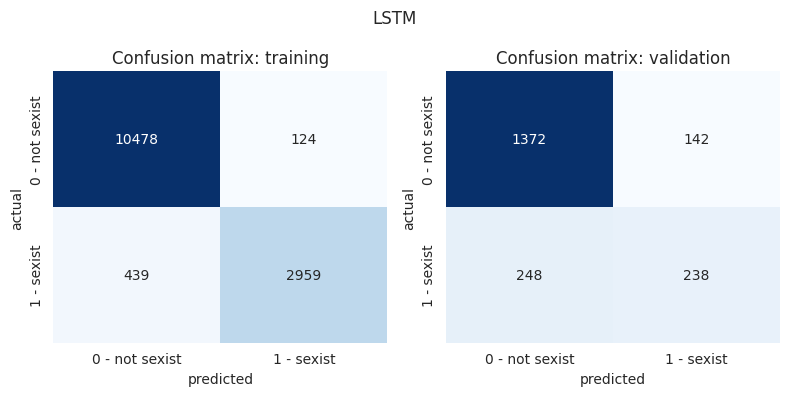

In [19]:
y_train = convert_labels_to_int(y_train)
y_balanced = convert_labels_to_int(y_balanced)
y_val = convert_labels_to_int(y_val)

rnn = LSTM_Model()
rnn.train(X_train, y_train, X_val, y_val)
res = rnn.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="LSTM")
for res_x in res:
    results.loc[len(results)] = res_x

In [ ]:
# y_train = convert_labels_to_int(y_train)
# y_balanced = convert_labels_to_int(y_balanced)
# y_val = convert_labels_to_int(y_val)
rnn.train(X_balanced, y_balanced, X_val, y_val)
res = rnn.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="LSTM")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

Epoch 1/10
313/313 [==============================] - 5s 13ms/step - loss: 0.6935 - accuracy: 0.5011 - val_loss: 0.6938 - val_accuracy: 0.2435
Epoch 2/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6935 - accuracy: 0.4917 - val_loss: 0.6920 - val_accuracy: 0.7555
Epoch 3/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6934 - accuracy: 0.4925 - val_loss: 0.6920 - val_accuracy: 0.7355
Epoch 4/10
110/313 [=========>....................] - ETA: 2s - loss: 0.6933 - accuracy: 0.5028

## Results

In [21]:
results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.757286,0.500000,0.000000,0.000000
1,Majority class,validation,0.757000,0.500000,0.000000,0.000000
2,Rule-based,training,0.716429,0.573208,0.388975,0.294879
3,Rule-based,validation,0.707500,0.563007,0.367292,0.281893
4,Naive Bayes,training,0.816714,0.666418,0.742991,0.374338
5,Naive Bayes,validation,0.797500,0.630137,0.688372,0.304527
6,Logistic Regression,training,0.821786,0.662968,0.800000,0.354326
7,Logistic Regression,validation,0.804500,0.627076,0.765363,0.281893
8,XGBoost (BOW),training,0.845929,0.690806,0.941637,0.389347
9,XGBoost (BOW),validation,0.799500,0.612597,0.770701,0.248971


In [22]:
balanced_results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.5000,0.500000,0.000000,0.000000
1,Majority class,validation,0.7570,0.500000,0.000000,0.000000
2,Naive Bayes,training,0.7080,0.708000,0.714699,0.692400
3,Naive Bayes,validation,0.6860,0.665465,0.405333,0.625514
4,Logistic Regression,training,0.7541,0.754100,0.787378,0.696200
5,Logistic Regression,validation,0.6780,0.604995,0.370066,0.462963
6,XGBoost (BOW),training,0.8417,0.841700,0.886276,0.784000
7,XGBoost (BOW),validation,0.7605,0.698606,0.506306,0.578189
8,XGBoost (TF-IDF),training,0.8690,0.869000,0.920273,0.808000
9,XGBoost (TF-IDF),validation,0.7575,0.686146,0.500942,0.547325


In [23]:
models_dict = {
    "Majority Class": majority_class_classifier,
    "Naive Bayes": naive_bayes_classifier,
    "Logistic Regression": log_reg_classifier,
    "XGBoost (BOW)": xg_boost_bow,
    "LSTM": rnn
}

predictions = get_all_predictions(models_dict, X_val[1], X_val_bow[1], y_val[1])

1/1 [==============================] - 0s 11ms/step


In [24]:
predictions

{'true': 'not sexist',
 'Majority Class': ['not sexist'],
 'Naive Bayes': array(['sexist'], dtype='<U10'),
 'Logistic Regression': array(['not sexist'], dtype='<U10'),
 'XGBoost (BOW)': ['not sexist'],
 'LSTM': 'not sexist'}

In [25]:
y_pred = rnn.predict(X_val)
y_pred = convert_labels_to_string(y_pred)
y_val = y_val if isinstance(y_val[0], str) else convert_labels_to_string(y_val)

false_negative_indices = [i for i in range(len(X_val)) if y_val[i] == 'sexist' and y_pred[i] == 'not sexist']
false_negative_sentences = [S_val[i] for i in false_negative_indices]
false_negative_sentences

63/63 [==============================] - 0s 3ms/step


['I agree with that but at the same time I know myself well enough to say I canâ\x80\x99t love a woman. The minute she begins to hit the wall and some hotter, younger women enters the picture, itâ\x80\x99s time for impulse control because Iâ\x80\x99m going to want that.',
 "aim for the head so she dosn't come back",
 "This guys gonna have a great time in the barracks. If they don't know who he is, they will the first time he takes a communal shower. Christ, the women Marines will even be giving him shit. Ooorah! Fuckin-A.",
 'until she\'s been around me long enough through real life situations where I can actually see who she really is Like observing her rage when the wifi connection is set to "shit-tier" on the router on purpose. ]=)',
 "I've only known 2 or 3 men in my entire life that micro managed their wives, girlfriends. It's exhausting and not worth it and most men are not that tiny, tiny minded, spiteful, hate filled and petty like a woman's mind is.",
 'Just block her, the dat

# Report on Misclassification Analysis of RNN Model

In [26]:
import random
random.seed(1234)
# Predict on the test set
y_pred_test = rnn.predict(X_test)

# Convert predictions and true labels to string format
y_pred_test = convert_labels_to_string(y_pred_test)
y_test = y_test if isinstance(y_test[0], str) else convert_labels_to_string(y_test)

# Identify indices for each confusion matrix quadrant
tp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'sexist']  # True Positives
tn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'not sexist']  # True Negatives
fp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'sexist']  # False Positives
fn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'not sexist']  # False Negatives

# Randomly sample up to 25 sentences from each quadrant
sampled_tp_test = random.sample(tp_indices_test, min(25, len(tp_indices_test)))
sampled_tn_test = random.sample(tn_indices_test, min(25, len(tn_indices_test)))
sampled_fp_test = random.sample(fp_indices_test, min(25, len(fp_indices_test)))
sampled_fn_test = random.sample(fn_indices_test, min(25, len(fn_indices_test)))

# Extract sentences for sampled indices
sampled_sentences_tp_test = [S_test[i] for i in sampled_tp_test]
sampled_sentences_tn_test = [S_test[i] for i in sampled_tn_test]
sampled_sentences_fp_test = [S_test[i] for i in sampled_fp_test]
sampled_sentences_fn_test = [S_test[i] for i in sampled_fn_test]

# Print the sampled sentences for analysis
print("Sampled True Positives (TP):")
for sentence in sampled_sentences_tp_test:
    print(sentence)

print("\nSampled True Negatives (TN):")
for sentence in sampled_sentences_tn_test:
    print(sentence)

print("\nSampled False Positives (FP):")
for sentence in sampled_sentences_fp_test:
    print(sentence)

print("\nSampled False Negatives (FN):")
for sentence in sampled_sentences_fn_test:
    print(sentence)


125/125 [==============================] - 0s 4ms/step
Sampled True Positives (TP):
Miss Pony [USER] posting her own home made porn photos Your one sick bitch !
keep talking, hag
I'm sure that kinder gentler baboon troop was soon overtaken by the dump defenders troop with the young being massacred and the females being taken as spoils. Yeah, sounds pretty great.
Absolutely! If these RINOs stab US all in the back - tossing their vote to the Democrats = WE WILL NEVER FORGET! It's a hardcore SMEAR CAMPAIGN w Hillary Clinton and her lawyers behind it all = EVIL BITCH.
you have a women that smashes other people's heads into lockers. son you need to lose that bitch now! and you think that you are the only she got on a string.
she lowers her prices with kids. Hang the Pedo bitvch
courage precludes the wise and strong from prostrating to his base emotions. let the woman freak out. were cooler under pressure, so lets be cool under pressure. let the women attack us physically, were stronger. bei

## Overview
We are going into an in depth analysis of the RNN model's misclassifications on the test dataset for a sexism detection task. It categorizes the sentences into four confusion matrix quadrants:
- **True Positives (TP):** Correctly classified as sexist.
- **True Negatives (TN):** Correctly classified as not sexist.
- **False Positives (FP):** Incorrectly classified as sexist.
- **False Negatives (FN):** Incorrectly classified as not sexist.

With this analysis we identify patterns in the misclassified samples and suggests improvements to enhance the model's performance.

---

## True Positives (TP)

### **Characteristics:**
- These sentences contain overt sexism, including:
  - Explicit slurs (e.g., "cunt," "bitch," "whore").
  - Objectifying women (e.g., "like a walking dildo").
  - Hostility towards women in power or feminists (e.g., "Fuck this stupid woman").
  - Stereotypes of traditional gender roles (e.g., "Don’t let women vote").

### **Patterns:**
- Use of explicit misogynistic slurs.
- Contextual misogyny targeting gender roles or political affiliations.
- Common references to male-dominant ideologies like MGTOW.

### **Examples:**
- "The sad reality is without sex, men don’t need or want women. But women desire and crave male attention, that’s why they are constantly invading and taking over male spaces."
- "That ho is nothing but a cat's full little box throw her to the dump!"
- "Wow, cheating is so easy and natural for women, that even women in their 80s can do it."

---

## True Negatives (TN)

### **Characteristics:**
- These sentences do not contain sexism and were correctly identified as not sexist.
- They include:
  - Neutral personal reflections (e.g., "My life is filled with things I love: video games, soccer, backpacking trips").
  - Discussions about unrelated topics (e.g., "Quality? I don’t know about you but Cap’s gay ass little arm shields ruined it for me").
  - Sarcastic or humorous comments unrelated to sexism.

### **Patterns:**
- Neutral language and context unrelated to sexism.
- Sarcasm or humor that lacks hostile undertones.
- Discussions focusing on non gender related issues.

### **Examples:**
- "LOL, a Canadian guy legally changed his gender to female so that he would save $1000 a year on car insurance."
- "Normal and normal, girls just don't find me attractive."
- "She stopped responding because there are probably 17 other guys talking to her at the same moment."

---

## False Positives (FP)

### **Characteristics:**
- Sentences incorrectly classified as sexist, possibly due to:
  - The presence of controversial or vulgar language.
  - Discussions of gender dynamics in neutral or balanced ways.
  - General references to feminists, MGTOW, or gendered terms (e.g., "Trouble with MGTOW is you take isolated incidents and judge all females like this").

### **Patterns:**
- Sentences discussing gender-related topics neutrally.
- Vulgar language unrelated to sexism (e.g., "Check the constitution, mother fucker").
- Balanced critique or reflections on societal issues involving gender.

### **Examples:**
- "You can’t get women because you have a shit personality. Maybe you are just creepy and it turns women away."
- "Women should be the first test group. No. They don't think that women should be the 'first test group.'"
- "Having a low sex drive to the point of being practically asexual is such a blessing... women have literally no effect or control over me."

### **Potential Causes:**
- Over-sensitivity to keywords like "women," "feminists," or "MGTOW."
- Lack of contextual understanding in distinguishing neutral discussions from sexism.

---

## False Negatives (FN)

### **Characteristics:**
- Sentences that contain sexism but were misclassified as not sexist.
- Often include:
  - Subtle or euphemistic sexism (e.g., "Women seemingly have endless amounts of time to waste").
  - Stereotypical gender roles (e.g., "Women talk for the sake of talking").
  - Sarcasm or coded language (e.g., "Chad is also catching regret rape claims later").

### **Patterns:**
- Subtle misogyny masked by indirect or sarcastic language.
- Stereotypical comments that lack explicit slurs but imply sexism.
- Euphemistic or metaphorical references to sexism.

### **Examples:**
- "This shows that there ain’t a limit to stupidity for females."
- "The boys should be killed. OK, now that we have that out of the way, why is a girl meeting two boys in a ditch to buy a knife?"

### **Potential Causes:**
- Lack of nuanced understanding of indirect sexism.
- Failure to detect sarcasm or rhetorical devices.

---